# Logistic Regression 
**Here we show one example of Logistic Regression using scikit-learn library. How to tune Hyperparameters using Grid and Random Search and Cross validation with several folds**

# Imports

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import OrdinalEncoder

from imblearn.over_sampling import SMOTE

from scipy.stats import expon

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# Helper Functions

In [2]:
def pie_plot(series, figsize=(7,7)):
    plt.figure(figsize=figsize)
    val_counts = series.value_counts()
    val_sum = val_counts.sum()
    plt.pie(val_counts, labels=val_counts.index,autopct=lambda p: '{:.1f}% ({:,})'.format(p,int(p*val_sum/100)));

In [3]:
def get_confusion_matrix(y_test, y_pred):
    return pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['True', 'False'], index=['Pred_True', 'Pred_False'])

In [4]:
def plot_roc_auc_curve(y_test, y_pred, clf, X_test):
    logit_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    plt.figure(figsize=[10,7])
    plt.plot(fpr, tpr,label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.plot(fpr, thresholds,'g:',label='Thresholds')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="upper right")
    plt.savefig('Log_ROC')
    plt.show()


# The Data

 The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe (1/0) a term deposit (variable y).

 This dataset provides the customer information. It includes over 41K records and 21 fields.


## Read Data

In [5]:
data = pd.read_csv('../data/banking.csv', header=0)

In [6]:
data.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1
5,30,management,divorced,basic.4y,no,yes,no,cellular,jul,tue,...,8,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,0
6,37,blue-collar,married,basic.4y,no,yes,no,cellular,may,thu,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.327,5099.1,0
7,39,blue-collar,divorced,basic.9y,no,yes,no,cellular,may,fri,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
8,36,admin.,married,university.degree,no,no,no,cellular,jun,mon,...,1,3,1,success,-2.9,92.963,-40.8,1.266,5076.2,1
9,27,blue-collar,single,basic.4y,no,yes,no,cellular,apr,thu,...,2,999,1,failure,-1.8,93.075,-47.1,1.410,5099.1,0


# Take only target and Numerical Features for Simplicity

## Numerical variable descriptions

- age (numeric)

- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

- previous: number of contacts performed before this campaign and for this client (numeric)

- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

- emp.var.rate: employment variation rate - (numeric)

- cons.price.idx: consumer price index - (numeric)

- cons.conf.idx: consumer confidence index - (numeric)

- euribor3m: euribor 3 month rate - (numeric)

- nr.employed: number of employees - (numeric)

In [7]:
num_cols = data.select_dtypes(include=np.number).columns

In [8]:
cat_cols = data.select_dtypes(include='object').columns

In [9]:
for col in cat_cols:
    print(f'----{col}----')
    print(data[col].value_counts(),'\n')

----job----
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64 

----marital----
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64 

----education----
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64 

----default----
no         32588
unknown     8597
yes            3
Name: default, dtype: int64 

----housing----
yes        21576
no         18622
unknown      990
Name: housing, dtype: int64 

----loan----
no         33950
yes         6248
unknown      990
Name: loan, dtype: int64 

-

In [10]:
data['month'] = data['month'].map({'jan':1,
                   'feb':2, 
                   'mar':3, 
                   'apr':4, 
                   'may':5,
                   'jun':6,
                   'jul':7,
                   'aug':8,
                   'sep':9,
                   'oct':10,
                   'nov':11,
                   'dec':12})

In [11]:
data['day_of_week'] = data['day_of_week'].map({'mon':1,
                         'tue':2,
                         'wed':3,
                         'thu':4,
                         'fri':5,
                         'sat':6,
                         'sun':7
                        })

In [12]:
cat_cols = data.select_dtypes(include='object').columns

In [13]:
cat_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'poutcome'],
      dtype='object')

In [14]:
ord_enc = OrdinalEncoder()

In [15]:
cat_data_1 = pd.DataFrame(data=ord_enc.fit_transform(data[cat_cols]),columns=cat_cols);
cat_data_1

,job,marital,education,default,housing,loan,contact,poutcome
0,1.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0
1,9.0,1.0,7.0,0.0,0.0,0.0,0.0,1.0
2,4.0,2.0,6.0,0.0,2.0,0.0,0.0,2.0
3,7.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0
4,5.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...
41183,5.0,1.0,3.0,1.0,0.0,2.0,1.0,1.0
41184,3.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
41185,0.0,2.0,6.0,1.0,2.0,2.0,1.0,1.0
41186,9.0,1.0,5.0,0.0,0.0,2.0,1.0,1.0


In [16]:
ord_enc.categories_

[array(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
        'retired', 'self-employed', 'services', 'student', 'technician',
        'unemployed', 'unknown'], dtype=object),
 array(['divorced', 'married', 'single', 'unknown'], dtype=object),
 array(['basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate',
        'professional.course', 'university.degree', 'unknown'],
       dtype=object),
 array(['no', 'unknown', 'yes'], dtype=object),
 array(['no', 'unknown', 'yes'], dtype=object),
 array(['no', 'unknown', 'yes'], dtype=object),
 array(['cellular', 'telephone'], dtype=object),
 array(['failure', 'nonexistent', 'success'], dtype=object)]

In [17]:
num_cols = data.select_dtypes(include=np.number).columns

In [18]:
data_1 = pd.concat((cat_data_1,data[num_cols]),axis=1)

In [19]:
data_1

,job,marital,education,default,housing,loan,contact,poutcome,age,month,...,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,1.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,44,8,...,210,1,999,0,1.4,93.444,-36.1,4.963,5228.1,0
1,9.0,1.0,7.0,0.0,0.0,0.0,0.0,1.0,53,11,...,138,1,999,0,-0.1,93.200,-42.0,4.021,5195.8,0
2,4.0,2.0,6.0,0.0,2.0,0.0,0.0,2.0,28,6,...,339,3,6,2,-1.7,94.055,-39.8,0.729,4991.6,1
3,7.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,39,4,...,185,2,999,0,-1.8,93.075,-47.1,1.405,5099.1,0
4,5.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0,55,8,...,137,1,3,1,-2.9,92.201,-31.4,0.869,5076.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,5.0,1.0,3.0,1.0,0.0,2.0,1.0,1.0,59,6,...,222,1,999,0,1.4,94.465,-41.8,4.866,5228.1,0
41184,3.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,31,5,...,196,2,999,0,1.1,93.994,-36.4,4.860,5191.0,0
41185,0.0,2.0,6.0,1.0,2.0,2.0,1.0,1.0,42,5,...,62,3,999,0,1.1,93.994,-36.4,4.857,5191.0,0
41186,9.0,1.0,5.0,0.0,0.0,2.0,1.0,1.0,48,10,...,200,2,999,0,-3.4,92.431,-26.9,0.742,5017.5,0


In [20]:
corr = data_1.corr(method='spearman')

In [21]:
corr

,job,marital,education,default,housing,loan,contact,poutcome,age,month,...,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
job,1.000000,-0.004491,0.014733,0.008965,0.003254,-0.012884,-0.004468,0.006871,0.024819,0.029766,...,-0.000748,-0.009943,-0.016066,0.007436,0.003509,0.003938,0.038500,0.007517,-0.000800,0.011541
marital,-0.004491,1.000000,0.118857,-0.087706,0.011519,0.005383,-0.058160,-0.000206,-0.428000,-0.014328,...,0.006252,-0.010641,-0.039152,0.038240,-0.067614,-0.063756,-0.040634,-0.071788,-0.071866,0.048296
education,0.014733,0.118857,1.000000,-0.181005,0.015212,0.005301,-0.105504,0.016496,-0.105224,0.135149,...,-0.019264,0.000381,-0.049511,0.032342,-0.018066,-0.074426,0.100768,-0.001548,-0.009706,0.061134
default,0.008965,-0.087706,-0.181005,1.000000,-0.015847,-0.002546,0.135411,0.026754,0.192404,-0.060560,...,-0.017097,0.033597,0.080063,-0.105290,0.177190,0.164980,0.033100,0.169507,0.157269,-0.099350
housing,0.003254,0.011519,0.015212,-0.015847,1.000000,0.038464,-0.082412,-0.012388,-0.004113,0.024129,...,-0.009863,-0.010626,-0.010675,0.024791,-0.049673,-0.086799,-0.033797,-0.037008,-0.034723,0.011574
loan,-0.012884,0.005383,0.005301,-0.002546,0.038464,1.000000,-0.005315,-0.002254,-0.007231,-0.004205,...,-0.011539,0.012809,0.000557,0.000300,0.004297,-0.002811,-0.010052,0.006697,0.004615,-0.005074
contact,-0.004468,-0.058160,-0.105504,0.135411,-0.082412,-0.005315,1.000000,0.125141,0.032814,-0.325720,...,-0.036420,0.069625,0.117994,-0.242008,0.231177,0.660197,0.265388,0.140998,0.109497,-0.144773
poutcome,0.006871,-0.000206,0.016496,0.026754,-0.012388,-0.002254,0.125141,1.000000,0.015238,0.077161,...,0.039040,0.032595,-0.451822,-0.496583,0.210419,0.225851,0.188181,0.179944,0.152291,0.120787
age,0.024819,-0.428000,-0.105224,0.192404,-0.004113,-0.007231,0.032814,0.015238,1.000000,0.063346,...,-0.002123,0.005715,-0.001062,-0.012643,0.045003,0.044790,0.114536,0.054391,0.044789,-0.011861
month,0.029766,-0.014328,0.135149,-0.060560,0.024129,-0.004205,-0.325720,0.077161,0.063346,1.000000,...,-0.057392,-0.010752,-0.067871,-0.015902,0.306792,-0.055136,0.347893,0.291432,0.411967,0.026813


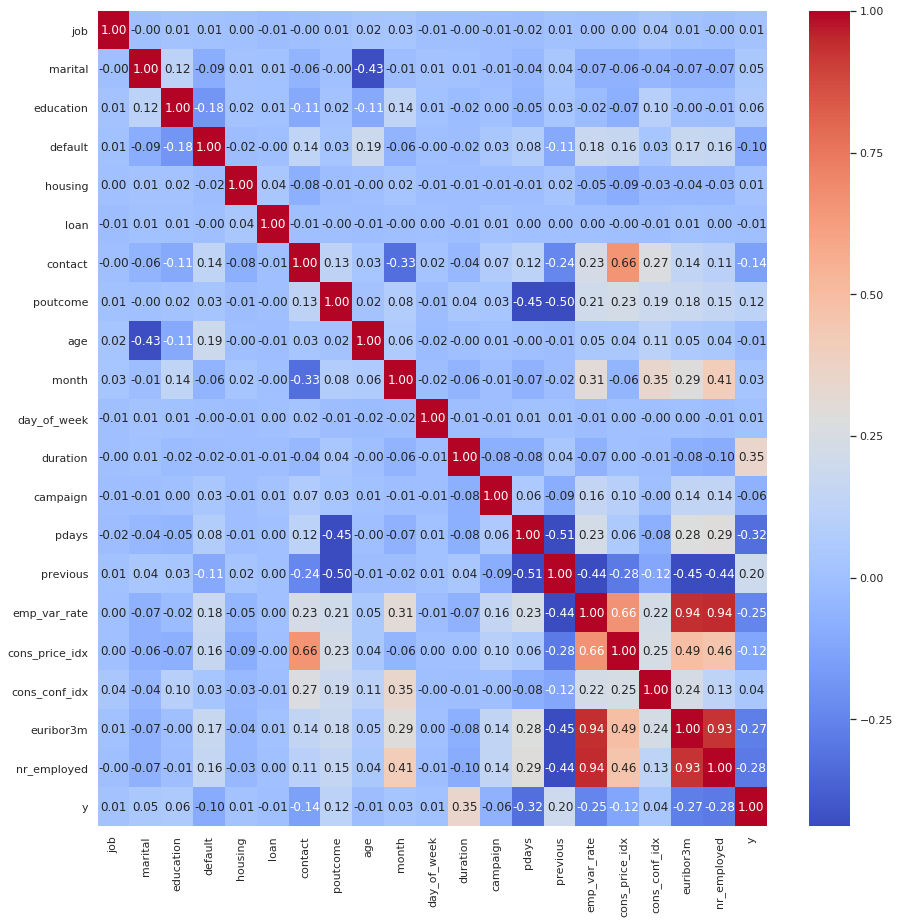

In [22]:
plt.subplots(1,1,figsize=(15,15))
sns.heatmap(corr, cmap='coolwarm',robust= True, annot=True,fmt='.2f',annot_kws={'size':12})

In [23]:
corr['y'].abs().sort_values(ascending=False).index

Index(['y', 'duration', 'pdays', 'nr_employed', 'euribor3m', 'emp_var_rate',
       'previous', 'contact', 'cons_price_idx', 'poutcome', 'default',
       'campaign', 'education', 'marital', 'cons_conf_idx', 'month', 'age',
       'housing', 'job', 'day_of_week', 'loan'],
      dtype='object')

In [24]:
data_1.groupby(by=['y','loan'])['loan'].count()

y  loan
0  0.0     30100
   1.0       883
   2.0      5565
1  0.0      3850
   1.0       107
   2.0       683
Name: loan, dtype: int64

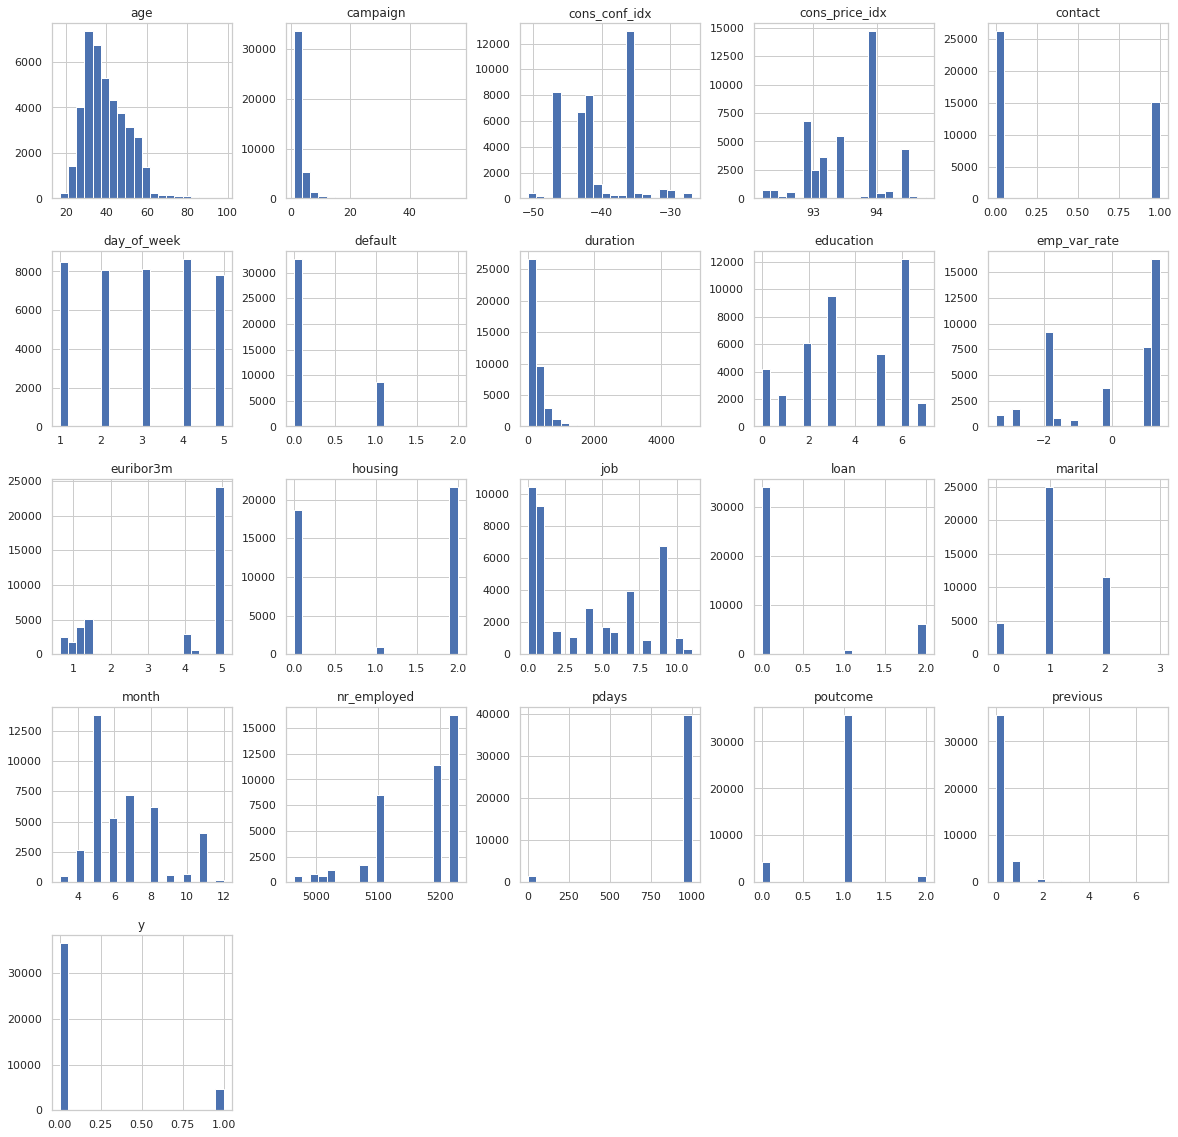

In [25]:
axlist = data_1.hist(bins=20, figsize=(20,20))

In [26]:
data_1.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'poutcome', 'age', 'month', 'day_of_week', 'duration', 'campaign',
       'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx',
       'euribor3m', 'nr_employed', 'y'],
      dtype='object')

In [27]:
numerical_features = ['age', 'campaign', 'pdays', 'duration', 'previous', 
                      'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

## Target variable:

y - has the client subscribed a term deposit? (binary: '1','0')

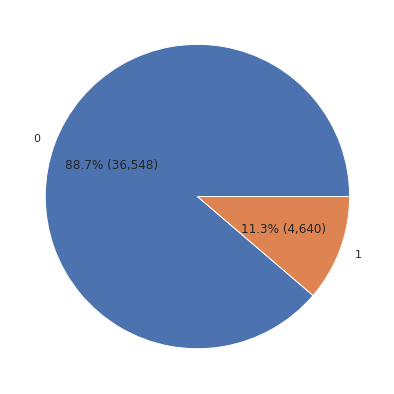

In [28]:
pie_plot(data_1.y)

## Take little part of the data to train models faster

In [29]:
data_1.sample(3)

,job,marital,education,default,housing,loan,contact,poutcome,age,month,...,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
31227,1.0,1.0,3.0,0.0,2.0,0.0,0.0,1.0,46,5,...,675,1,999,0,-1.8,92.893,-46.2,1.344,5099.1,0
13939,7.0,1.0,3.0,0.0,2.0,2.0,0.0,1.0,57,5,...,473,3,999,0,-1.8,92.893,-46.2,1.244,5099.1,1
14799,4.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,52,6,...,62,4,999,0,1.4,94.465,-41.8,4.961,5228.1,0


In [30]:
data_sample = data_1 #data.sample(10000)

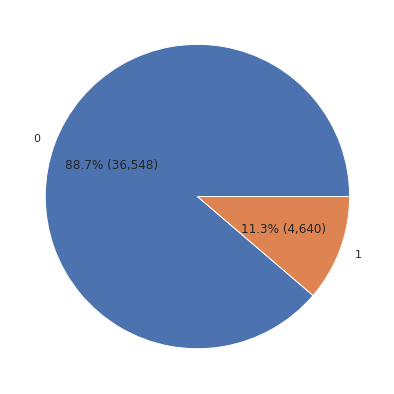

In [31]:
pie_plot(data_sample['y'])

## divide data into features and target

In [32]:
data_1.iloc[:,:-1]

,job,marital,education,default,housing,loan,contact,poutcome,age,month,day_of_week,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,1.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,44,8,4,210,1,999,0,1.4,93.444,-36.1,4.963,5228.1
1,9.0,1.0,7.0,0.0,0.0,0.0,0.0,1.0,53,11,5,138,1,999,0,-0.1,93.200,-42.0,4.021,5195.8
2,4.0,2.0,6.0,0.0,2.0,0.0,0.0,2.0,28,6,4,339,3,6,2,-1.7,94.055,-39.8,0.729,4991.6
3,7.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,39,4,5,185,2,999,0,-1.8,93.075,-47.1,1.405,5099.1
4,5.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0,55,8,5,137,1,3,1,-2.9,92.201,-31.4,0.869,5076.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,5.0,1.0,3.0,1.0,0.0,2.0,1.0,1.0,59,6,4,222,1,999,0,1.4,94.465,-41.8,4.866,5228.1
41184,3.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,31,5,4,196,2,999,0,1.1,93.994,-36.4,4.860,5191.0
41185,0.0,2.0,6.0,1.0,2.0,2.0,1.0,1.0,42,5,3,62,3,999,0,1.1,93.994,-36.4,4.857,5191.0
41186,9.0,1.0,5.0,0.0,0.0,2.0,1.0,1.0,48,10,2,200,2,999,0,-3.4,92.431,-26.9,0.742,5017.5


In [120]:
X = data_1.iloc[:,:-1]
y = data_1['y']

In [121]:
X.shape, y.shape

((41188, 20), (41188,))

# Oversample the minority class by synthetically generating additional samples

In [122]:
os = SMOTE(random_state=0, sampling_strategy=1)
X, y = os.fit_resample(X, y)

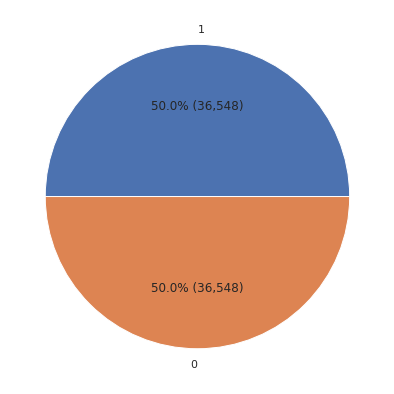

In [123]:
pie_plot(pd.Series(y))

In [124]:
X.shape

(73096, 20)

# Logistic Regression Model Fitting

## Split data into train and test sets

Here we won't see effect of stratify because we have balanced target. The use of stratify is to have the same distribution of target in train and test splits

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [126]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((51167, 20), (21929, 20), (51167,), (21929,))

## Create Logistic Regression classifier

In [127]:
clf = LogisticRegression()

In [41]:
clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [42]:
clf.tol = 0.001
clf.max_iter = 150

In [45]:
clf.score?

## Create Parameter Grids

### GridSearchCV

Here we are going to create several splits of training data (K-folds) and then we are going to run grid search on every split. 
We will check calculated scores distributions on each split.

parameter grid defines several choises for each hyperparameter we need to tune

In [46]:
grid_parameters = {'penalty' : ['l2'],
     'C' : np.logspace(-3, 1, num=10,base=10),
     'solver' : ['liblinear','lbfgs'],
    }

In [47]:
with np.printoptions(precision=5,suppress=True):
    print(np.logspace(-3,1, num=10,base=10))

[ 0.001    0.00278  0.00774  0.02154  0.05995  0.16681  0.46416  1.29155
  3.59381 10.     ]


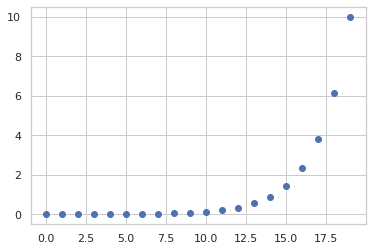

In [48]:
plt.scatter(x=range(20),y=np.logspace(-3, 1, num=20,base=10))

## Create grid search object

- cv: cross validation (number of splits to do in data for cross validation the same as K-fold)
- verbose: to show some logs while training
- n_jobs: uses parallel runs for training different models (-1 means "all")

There will be **CV*|PARAMS|** = **5x(20x2x1)** models trained (all combinations of parameters times number of splits)

In [49]:
grid_clf = GridSearchCV(estimator=clf, param_grid=grid_parameters, cv=5, verbose=True, n_jobs=-1)

In [50]:
grid_clf.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 150,
 'estimator__multi_class': 'auto',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 0.001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=150,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.001, verbose=0,
                    warm_start=False),
 'iid': 'deprecated',
 'n_jobs': -1,
 'param_grid': {'penalty': ['l2'],
  'C': array([1.00000000e-03, 2.78255940e-03, 7.74263683e-03, 2.15443469e-02,
         5.99484250e

###  RandomizedSearchCV

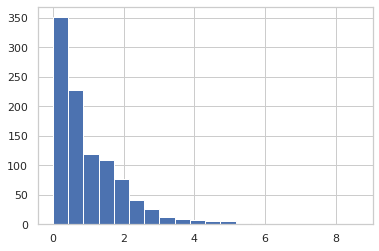

In [51]:
pd.Series(expon.rvs(size=1000)).hist(bins=20)

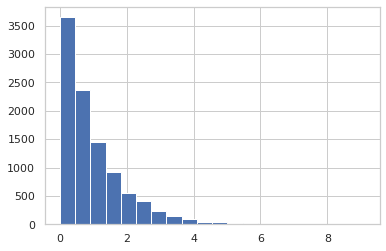

In [52]:
hist_arr, x_axis_arr, some_arr = plt.hist(expon.rvs(size=10000),bins=20)

In [53]:
hist_arr

array([3.648e+03, 2.372e+03, 1.452e+03, 9.290e+02, 5.510e+02, 4.180e+02,
       2.340e+02, 1.480e+02, 1.010e+02, 4.800e+01, 3.500e+01, 2.300e+01,
       1.600e+01, 9.000e+00, 6.000e+00, 2.000e+00, 1.000e+00, 3.000e+00,
       3.000e+00, 1.000e+00])

In [54]:
x_axis_arr

array([4.90349120e-05, 4.55390570e-01, 9.10732105e-01, 1.36607364e+00,
       1.82141518e+00, 2.27675671e+00, 2.73209825e+00, 3.18743978e+00,
       3.64278132e+00, 4.09812285e+00, 4.55346439e+00, 5.00880592e+00,
       5.46414746e+00, 5.91948899e+00, 6.37483053e+00, 6.83017206e+00,
       7.28551360e+00, 7.74085513e+00, 8.19619667e+00, 8.65153820e+00,
       9.10687974e+00])

In [55]:
np.sort(expon.rvs(size=20),kind='mergesort')

array([0.00717154, 0.02655053, 0.08538535, 0.1051619 , 0.10647735,
       0.2665999 , 0.37134128, 0.38816557, 0.49354539, 0.5693738 ,
       0.92448092, 0.95095626, 1.02140541, 1.13083145, 1.22543416,
       1.25849518, 1.47739946, 2.32941816, 2.87801183, 3.87002919])

In [56]:
%precision

'%r'

In [57]:
expon.cdf(np.linspace(0,7,50))

array([0.        , 0.1331221 , 0.24852271, 0.34856094, 0.43528188,
       0.51045834, 0.57562715, 0.63212056, 0.68109344, 0.72354695,
       0.76034896, 0.79225181, 0.81990769, 0.84388195, 0.86466472,
       0.88268083, 0.89829861, 0.91183731, 0.92357371, 0.93374774,
       0.94256738, 0.95021293, 0.95684069, 0.96258615, 0.96756676,
       0.97188434, 0.97562716, 0.97887172, 0.98168436, 0.98412258,
       0.98623621, 0.98806848, 0.98965683, 0.99103373, 0.99222734,
       0.99326205, 0.99415902, 0.99493659, 0.99561064, 0.99619496,
       0.99670149, 0.9971406 , 0.99752125, 0.99785122, 0.99813727,
       0.99838524, 0.9986002 , 0.99878655, 0.99894808, 0.99908812])

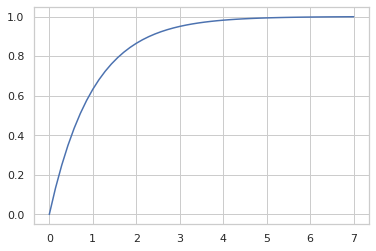

In [58]:
plt.plot(np.linspace(0,7,50),expon.cdf(np.linspace(0,7,50)))

### Randomized Grid search searches parameters not from predefined list of parameters but randomly generated parameters

There will be **CV*|iters|** = **5x20** models trained (n random combinations of parameters times number of splits)

In [59]:
random_parameters = {'penalty' : ['l2'],
     'C' : expon.rvs(size=20),
     'solver' : ['liblinear','lbfgs'],
    }

In [60]:
random_clf = RandomizedSearchCV(estimator=clf,
                                   random_state=42, 
                                   param_distributions=random_parameters, 
                                   cv=5, 
                                   verbose=True,
                                   n_jobs=-1, 
                                   n_iter=20)

## Using RandomizedSearchCV

## Fit on data

In [61]:
best_param_grid_clf = grid_clf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   35.1s finished


In [62]:
best_param_random_clf = random_clf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.8s finished


## Check Score Distributions on splits

In [63]:
grid_clf.cv_results_

{'mean_fit_time': array([0.83515654, 1.70915756, 0.759973  , 1.73997121, 0.81302376,
        1.72056293, 0.87348523, 1.6924664 , 0.90853629, 1.7632834 ,
        0.91788316, 1.71773958, 0.84314971, 1.76733112, 0.74103422,
        1.67284088, 0.87748141, 1.67861214, 0.85576315, 1.51256747]),
 'std_fit_time': array([0.12245252, 0.08551127, 0.12181862, 0.04369863, 0.17496262,
        0.0738813 , 0.18042434, 0.1005241 , 0.15984742, 0.0655629 ,
        0.25226157, 0.07609464, 0.11835343, 0.08103411, 0.09728733,
        0.08166386, 0.06747436, 0.05473422, 0.13026526, 0.21146991]),
 'mean_score_time': array([0.03105569, 0.00492916, 0.00612063, 0.00479074, 0.00577402,
        0.0049439 , 0.00587697, 0.00440679, 0.0057447 , 0.00567927,
        0.00651951, 0.00494761, 0.0069262 , 0.00484533, 0.00628982,
        0.00549135, 0.00620317, 0.0046392 , 0.00601401, 0.00377183]),
 'std_score_time': array([0.02277687, 0.0002804 , 0.00035214, 0.00043587, 0.00096848,
        0.00037287, 0.00108979, 0.000342

In [66]:
pd.DataFrame(grid_clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.835157,0.122453,0.031056,0.022777,0.001,l2,liblinear,"{'C': 0.001, 'penalty': 'l2', 'solver': 'libli...",0.859683,0.868575,0.858888,0.858595,0.859767,0.861102,0.003764,9
1,1.709158,0.085511,0.004929,0.000280,0.001,l2,lbfgs,"{'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}",0.858511,0.863006,0.856152,0.856836,0.858595,0.858620,0.002388,17
2,0.759973,0.121819,0.006121,0.000352,0.00278256,l2,liblinear,"{'C': 0.0027825594022071257, 'penalty': 'l2', ...",0.855970,0.868282,0.858790,0.858399,0.864947,0.861278,0.004586,8
3,1.739971,0.043699,0.004791,0.000436,0.00278256,l2,lbfgs,"{'C': 0.0027825594022071257, 'penalty': 'l2', ...",0.856752,0.859097,0.856836,0.856738,0.858692,0.857623,0.001047,20
4,0.813024,0.174963,0.005774,0.000968,0.00774264,l2,liblinear,"{'C': 0.007742636826811269, 'penalty': 'l2', '...",0.856068,0.869846,0.864165,0.858595,0.859572,0.861649,0.004864,7
5,1.720563,0.073881,0.004944,0.000373,0.00774264,l2,lbfgs,"{'C': 0.007742636826811269, 'penalty': 'l2', '...",0.859097,0.863397,0.859181,0.856738,0.860451,0.859773,0.002173,11
6,0.873485,0.180424,0.005877,0.001090,0.0215443,l2,liblinear,"{'C': 0.021544346900318832, 'penalty': 'l2', '...",0.859586,0.869650,0.863676,0.863579,0.859767,0.863252,0.003655,4
7,1.692466,0.100524,0.004407,0.000343,0.0215443,l2,lbfgs,"{'C': 0.021544346900318832, 'penalty': 'l2', '...",0.858804,0.858218,0.856836,0.857129,0.860061,0.858209,0.001169,19
8,0.908536,0.159847,0.005745,0.000386,0.0599484,l2,liblinear,"{'C': 0.05994842503189409, 'penalty': 'l2', 's...",0.855970,0.867305,0.864360,0.861526,0.868758,0.863584,0.004548,3
9,1.763283,0.065563,0.005679,0.001324,0.0599484,l2,lbfgs,"{'C': 0.05994842503189409, 'penalty': 'l2', 's...",0.857729,0.864081,0.855858,0.856640,0.859963,0.858854,0.002956,15


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbafc89d1f0>,
      dtype=object)

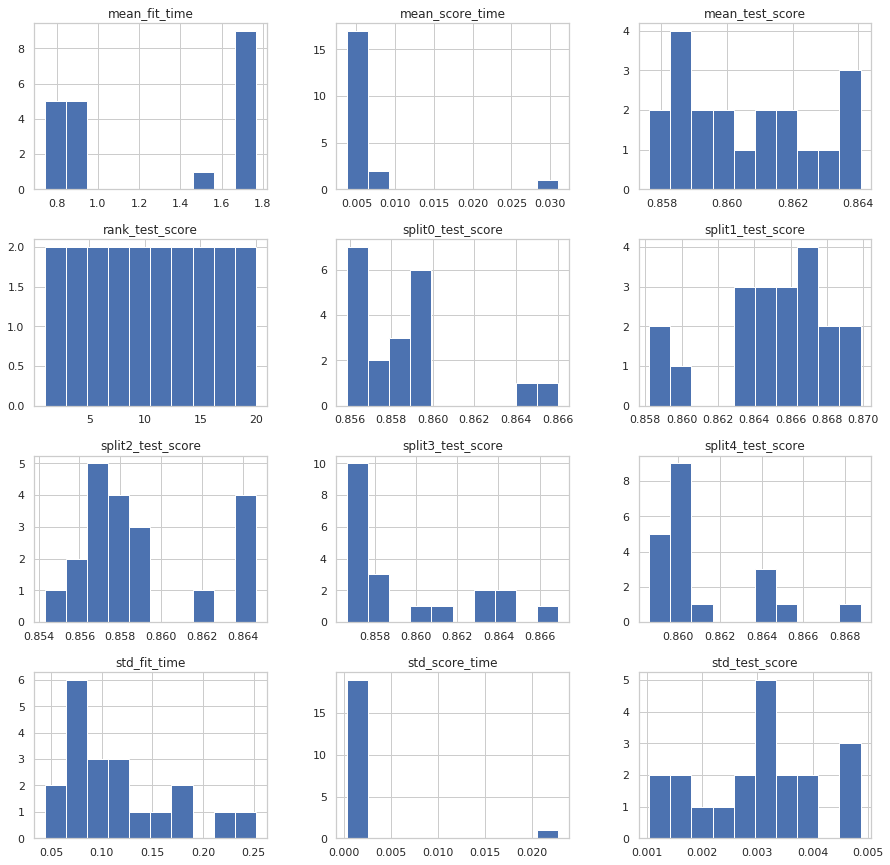

In [67]:
pd.DataFrame(grid_clf.cv_results_).hist(figsize=(15,15))

In [68]:
best_param_random_clf.cv_results_

{'mean_fit_time': array([1.81045933, 0.85719495, 1.69151387, 0.84037371, 0.93628931,
        0.92817702, 1.68818917, 1.63966551, 1.69406967, 0.79049506,
        1.67715993, 1.64510722, 1.66282988, 1.76425633, 0.76763401,
        1.02411132, 1.74219332, 0.89051065, 0.83917027, 1.46529021]),
 'std_fit_time': array([0.01792635, 0.14984809, 0.06081187, 0.11990814, 0.21873349,
        0.17157989, 0.03583099, 0.032471  , 0.04568539, 0.12914526,
        0.05544184, 0.03622373, 0.03297413, 0.09285905, 0.1163789 ,
        0.18709017, 0.03941406, 0.10495623, 0.1383089 , 0.30146136]),
 'mean_score_time': array([0.00487814, 0.00614648, 0.005163  , 0.00618238, 0.00645881,
        0.00600257, 0.00424151, 0.00412912, 0.00484533, 0.00575657,
        0.00448389, 0.00466189, 0.0045763 , 0.00504436, 0.00572691,
        0.00596962, 0.0044796 , 0.00686874, 0.00656347, 0.00374842]),
 'std_score_time': array([0.00040983, 0.00049075, 0.00081142, 0.00089255, 0.00147925,
        0.00063841, 0.00027849, 0.000185

In [69]:
pd.DataFrame(random_clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,param_penalty,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.810459,0.017926,0.004878,0.000410,lbfgs,l2,1.26605,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1.26...",0.860074,0.864569,0.856836,0.856347,0.861331,0.859831,0.003029,11
1,0.857195,0.149848,0.006146,0.000491,liblinear,l2,1.10927,"{'solver': 'liblinear', 'penalty': 'l2', 'C': ...",0.855873,0.867012,0.864263,0.863872,0.863774,0.862959,0.003737,5
2,1.691514,0.060812,0.005163,0.000811,lbfgs,l2,1.89595,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1.89...",0.859195,0.861638,0.856836,0.856738,0.859767,0.858835,0.001857,17
3,0.840374,0.119908,0.006182,0.000893,liblinear,l2,2.65524,"{'solver': 'liblinear', 'penalty': 'l2', 'C': ...",0.864765,0.865644,0.858302,0.863579,0.859670,0.862392,0.002890,6
4,0.936289,0.218733,0.006459,0.001479,liblinear,l2,0.7072,"{'solver': 'liblinear', 'penalty': 'l2', 'C': ...",0.870041,0.865644,0.861722,0.858302,0.859670,0.863076,0.004274,4
5,0.928177,0.171580,0.006003,0.000638,liblinear,l2,2.16581,"{'solver': 'liblinear', 'penalty': 'l2', 'C': ...",0.855873,0.869552,0.861722,0.863970,0.866999,0.863623,0.004698,2
6,1.688189,0.035831,0.004242,0.000278,lbfgs,l2,0.528316,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.52...",0.858609,0.864178,0.856836,0.857129,0.858497,0.859050,0.002661,16
7,1.639666,0.032471,0.004129,0.000185,lbfgs,l2,2.65524,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 2.65...",0.858511,0.865058,0.856445,0.856543,0.859767,0.859265,0.003154,12
8,1.694070,0.045685,0.004845,0.000501,lbfgs,l2,0.400567,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.40...",0.858804,0.861051,0.856738,0.857422,0.859181,0.858639,0.001499,20
9,0.790495,0.129145,0.005757,0.000509,liblinear,l2,0.379771,"{'solver': 'liblinear', 'penalty': 'l2', 'C': ...",0.855873,0.867012,0.864165,0.858302,0.863872,0.861845,0.004109,7


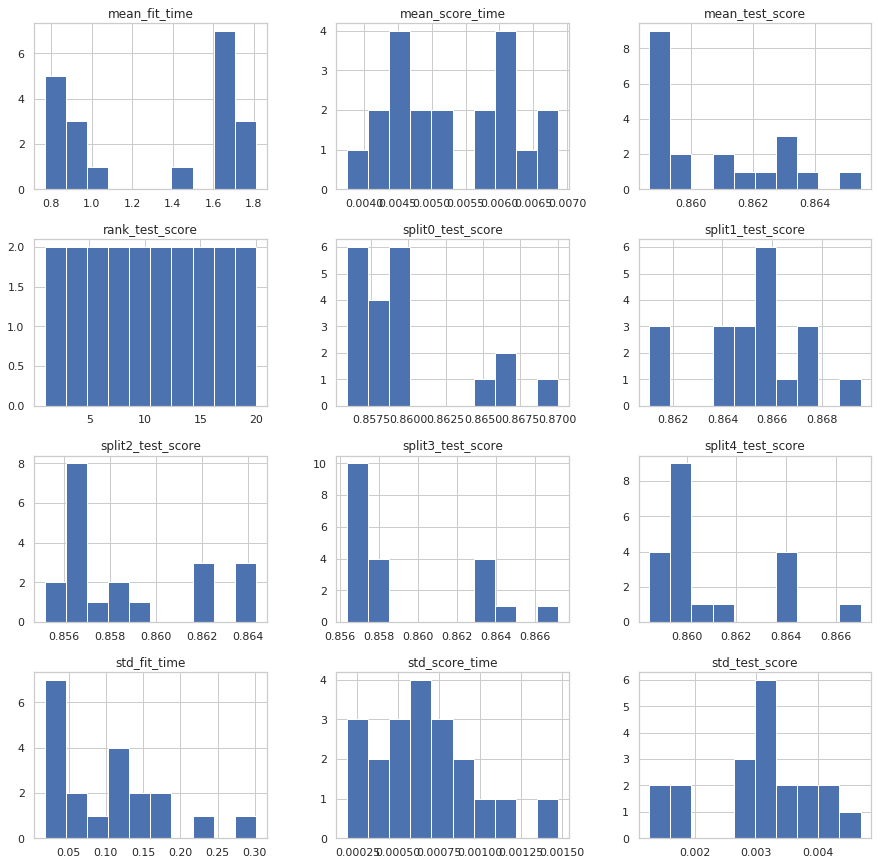

In [70]:
pd.DataFrame(random_clf.cv_results_).hist(figsize=(15, 15));

## Check Best parameter models

In [73]:
best_param_grid_clf.best_params_

{'C': 3.593813663804626, 'penalty': 'l2', 'solver': 'liblinear'}

In [74]:
best_param_random_clf.best_params_

{'solver': 'liblinear', 'penalty': 'l2', 'C': 1.160003302444781}

## Predict on test data using best model

In [75]:
y_pred_grid = best_param_grid_clf.predict(X_test)

In [76]:
y_pred_random = best_param_random_clf.predict(X_test)

## Confusion Matrices

In [77]:
get_confusion_matrix(y_test, y_pred_grid)

,True,False
Pred_True,9367,1598
Pred_False,1505,9459


In [78]:
get_confusion_matrix(y_test, y_pred_random)

,True,False
Pred_True,9315,1650
Pred_False,1497,9467


In [111]:
np.set_printoptions(precision=2,suppress=True)

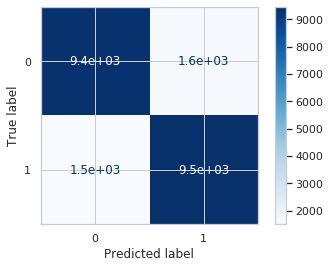

In [128]:
np.set_printoptions(precision=2,suppress=True)
plot_confusion_matrix(best_param_grid_clf,X_test,y_test,cmap=plt.cm.Blues)
plt.show()

## classification reports

In [129]:
print(classification_report(y_test, y_pred_grid))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86     10965
           1       0.86      0.86      0.86     10964

    accuracy                           0.86     21929
   macro avg       0.86      0.86      0.86     21929
weighted avg       0.86      0.86      0.86     21929



In [130]:
y_test[y_test==0].shape, y_test[y_test==1].shape

((10965,), (10964,))

In [131]:
print(classification_report(y_test, y_pred_random))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86     10965
           1       0.85      0.86      0.86     10964

    accuracy                           0.86     21929
   macro avg       0.86      0.86      0.86     21929
weighted avg       0.86      0.86      0.86     21929



## ROC-AUC curves

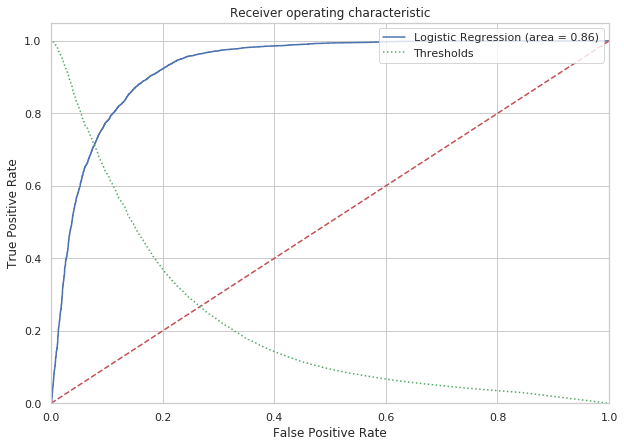

In [96]:
plot_roc_auc_curve(y_test, y_pred_grid, best_param_grid_clf, X_test)

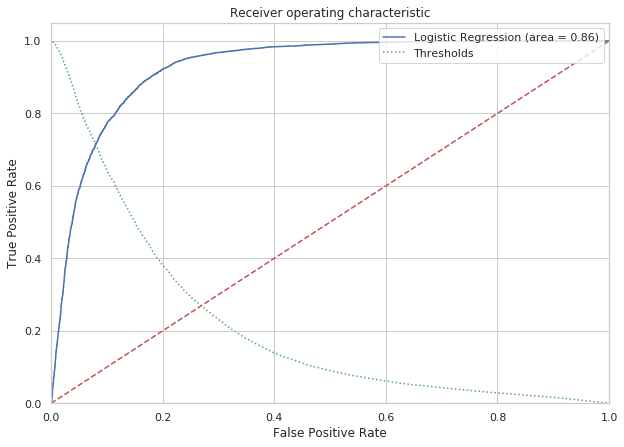

In [97]:
plot_roc_auc_curve(y_test, y_pred_random, best_param_random_clf, X_test)

In [98]:
tp, fp, fn, tn = confusion_matrix(y_test, y_pred_grid).ravel()

In [99]:
false_positive_rate = fp/(fp+tn)

In [100]:
true_positive_rate = tp/(tp+fn)

In [101]:
print('false_positive_rate = {:.4f}'.format(false_positive_rate))
print('true_positive_rate = {:.4f}'.format(true_positive_rate))

false_positive_rate = 0.1445
true_positive_rate = 0.8616


In [102]:
fpr, tpr, thresholds = roc_curve(y_test, best_param_grid_clf.predict_proba(X_test)[:,1])

In [103]:
roc_data = pd.DataFrame({'fpr':fpr,'tpr':tpr, 'thresholds':thresholds})

In [104]:
roc_data

,fpr,tpr,thresholds
0,0.000000,0.000000,2.000000
1,0.000091,0.000000,1.000000
2,0.000091,0.000821,1.000000
3,0.000182,0.000821,1.000000
4,0.000182,0.001368,1.000000
...,...,...,...
4332,0.801003,0.999818,0.034847
4333,0.801003,0.999909,0.034825
4334,0.849065,0.999909,0.028858
4335,0.849065,1.000000,0.028849


In [105]:
roc_data.loc[(roc_data['fpr']>0.1360) & (roc_data['fpr']<0.1387)]

,fpr,tpr,thresholds
2369,0.136069,0.846224,0.526143
2370,0.136069,0.846315,0.525966
2371,0.136252,0.846315,0.525540
2372,0.136252,0.846406,0.525496
2373,0.136434,0.846406,0.525342
2374,0.136434,0.846498,0.525192
2375,0.136525,0.846498,0.525134
2376,0.136525,0.846680,0.524907
2377,0.136617,0.846680,0.524761
2378,0.136617,0.846954,0.524457
